## TESTING HSDS

* works on Kestrel
* conda: buildouts (with pysam=4.1.0 and reV=0.8.2)
* reading in ACTIVSg grid files

In [2]:
## to see current python kernel in use:
## (too find your kernel in the dropdow do:
##
import sys

sys.executable

'/projects/hpcapps/isatkaus/conda-envs/buildouts/bin/python'

In [3]:
import os
from reV import TESTDATADIR
from reV.config.project_points import ProjectPoints
from reV.generation.generation import Gen

import numpy as np
import matplotlib.pyplot as plt
import json


import rex
from rex import Resource

import h5py
import glob

In [4]:
import pandas as pd
import numpy as np
import time
import os

#### not using pywwtk anymore, using eaw wtk data instead
# # set PYWTK_CACHE_DIR to locate WIND Toolkit data
# # will download from AWS as needed
# os.environ["PYWTK_CACHE_DIR"] = os.path.join(os.environ["HOME"], "pywtk-data")

from powerscenarios.parser import Parser
from powerscenarios.grid import Grid

# show multiple cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", 8)
pd.set_option("display.max_columns", 30)

# plotting (optional)
import cufflinks as cl

cl.go_offline()

In [4]:
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

In [5]:
import geopandas as gpd
import contextily as ctx
import shapely

# same as above but using shapely.Point
from shapely.geometry import Point, LineString, Polygon

from pyproj import Proj, transform
import rasterio
from rasterio.plot import show
import pyproj

import h5pyd

In [6]:
import PySAM
import reV

print(f"nrel-pysam version {PySAM.__version__}")
print(f"nrel-reV verion: {reV.__version__}")
print(f"python version: {sys.version}")

nrel-pysam version 4.1.0
nrel-reV verion: 0.8.2
python version: 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]


## OPTIONAL: load TAMU grid data
* choose TAMU grid - uncomment appropriate line
* grid files can be downloaded from:
* https://electricgrids.engr.tamu.edu/electric-grid-test-cases/

In [7]:
grid_name = "ACTIVSg200"  # TAMU 200 bus case
# grid_name = "ACTIVSg2000"  # TAMU 2000 bus case
# grid_name = 'ACTIVSg10k' # TAMU 10000 bus case
# grid_name = 'ACTIVSg70k' # TAMU 70000 bus case


# path to .aux file (TAMU grids) obtained from e.g.
# https://electricgrids.engr.tamu.edu/electric-grid-test-cases/activsg200/
data_dir = "/projects/hpcapps/isatkaus/grid-buildouts-data/grid-data/"
# aux_file_name = data_dir + grid_name + "/" + grid_name + ".aux"
aux_file_name = os.path.join(data_dir, grid_name, grid_name + ".aux")

# parse original .aux file and return dataframes for buses, generators, and wind generators
# here, we need .aux files because those are the only ones with Latitute/Longitude information
parser = Parser()
bus_df, gen_df, wind_gen_df = parser.parse_tamu_aux(aux_file_name)

# see what you got
print("bus_df:")
bus_df
print("gen_df:")
gen_df
print("wind_gen_df:")
wind_gen_df

grid = Grid(grid_name, bus_df, gen_df, wind_gen_df)
grid
print(grid.info())


# branches
# m_filename = data_dir + "/grid-data/" + grid_name + "/case_" + grid_name + ".m"
m_filename = os.path.join(data_dir + grid_name + "/case_" + grid_name + ".m")

# read branch table from scenarios_m_file
table_name = "mpc.branch"
column_names = [
    "fbus",
    "tbus",
    "r",
    "x",
    "b",
    "rateA",
    "rateB",
    "rateC",
    "ratio",
    "angle",
    "status",
    "angmin",
    "angmax",
    "Pf",
    "Qf",
    "Pt",
    "Qt",
    "mu_Sf",
    "mu_St",
    "mu_angmin",
    "mu_angmax",
]

# this table is entirely numeric
numeric_columns = column_names

branch_df = parser.read_m_table(
    m_filename,
    table_name=table_name,
    column_names=column_names,
    numeric_columns=numeric_columns,
)


# rename a few columns to match branch drawing script
branch_df.index.rename("UID", inplace=True)
branch_df.rename(columns={"fbus": "FromBus", "tbus": "ToBus"}, inplace=True)
print("\nbranch_df")
branch_df

# ############usts data
# usts_data_dir = "/Users/isatkaus/projects/ecp/powerscenarios/data/grid-data/USATestSystem/formatted/"

# filename = os.path.join(usts_data_dir, "branch.csv")
# branch_df = pd.read_csv(filename, index_col=0)
# print("\nbranch_df")
# branch_df

bus_df:


,BusNum,BusName,Latitude,Longitude,Zone
0,1,CREVECOEUR0,40.642116,-89.599560,2
1,2,CREVECOEUR1,40.642116,-89.599560,2
2,3,ILLIOPOLIS0,39.866030,-89.251291,4
3,4,ILLIOPOLIS1,39.866030,-89.251291,4
...,...,...,...,...,...
196,197,GIBSONCITY12,40.470500,-88.398700,6
197,198,MAPLETON0,40.556403,-89.762073,2
198,199,GIFFORD0,40.306027,-87.958606,6
199,200,PETERSBURG0,40.169931,-89.986537,4


gen_df:


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,49,1,4.530000,1.360000,1.0,Coal,49_Coal_1,RANTOUL21,40.312222,-88.159444,6
1,50,1,4.530000,1.360000,1.0,Coal,50_Coal_1,RANTOUL22,40.312222,-88.159444,6
2,51,1,4.530000,1.360000,1.0,Coal,51_Coal_1,RANTOUL23,40.312222,-88.159444,6
3,52,1,4.530000,1.360000,1.0,Coal,52_Coal_1,RANTOUL24,40.312222,-88.159444,6
...,...,...,...,...,...,...,...,...,...,...,...
45,183,1,26.600000,7.980000,1.0,Coal,183_Coal_1,SPRINGFIELD22,39.806868,-89.641653,4
46,189,1,569.150019,170.749998,1.0,Nuclear,189_Nuclear_1,CLINTON12,40.171900,-88.833900,7
47,196,1,67.500001,20.250000,1.0,NaturalGas,196_NaturalGas_1,GIBSONCITY11,40.470500,-88.398700,6
48,197,1,67.500001,20.250000,1.0,NaturalGas,197_NaturalGas_1,GIBSONCITY12,40.470500,-88.398700,6


wind_gen_df:


,BusNum,GenID,GenMWMax,GenMWMin,GenWindPowerFactor,GenFuelType,GenUID,BusName,Latitude,Longitude,Zone
0,65,1,150.399995,45.120001,1.0,Wind,65_Wind_1,PAXTON11,40.46405,-88.021517,6
1,104,1,99.000001,29.699999,1.0,Wind,104_Wind_1,ELLSWORTH12,40.47920,-88.798900,7
2,105,1,198.000002,59.400004,1.0,Wind,105_Wind_1,ELLSWORTH13,40.47920,-88.798900,7
3,114,1,1.700000,0.510000,1.0,Wind,114_Wind_1,NORMAL22,40.53700,-89.019000,7
4,115,1,150.000000,44.999999,1.0,Wind,115_Wind_1,NORMAL23,40.53700,-89.019000,7
5,147,1,100.500000,30.149999,1.0,Wind,147_Wind_1,HOPEDALE21,40.36920,-89.402200,7


Grid(name=ACTIVSg200, buses=200, generators=49, wind_generators=6, wind_sites=0)


ACTIVSg200 grid info: 

 number of buses: 200
 number of generators: 49
 number of wind generators: 6
 number of solar generators: 0
 total generator capacity: 3602.84 MW
 wind capacity/penetration: 699.60 MW / 19.42%
 solar capacity/penetration: 0.00 MW / 0.00%

branch_df


,FromBus,ToBus,r,x,b,rateA,rateB,rateC,ratio,angle,status,angmin,angmax,Pf,Qf,Pt,Qt,mu_Sf,mu_St,mu_angmin,mu_angmax
UID,,,,,,,,,,,,,,,,,,,,,
0,2,1,0.000673,0.003339,0.00000,100.0,0,0,0,0,1,0,0,-7.39,-2.10,7.39,2.11,0.0,0.0,0.0,0.0
1,1,119,0.018542,0.119758,0.02285,221.1,0,0,0,0,1,0,0,12.25,-0.57,-12.22,-1.63,0.0,0.0,0.0,0.0
2,124,1,0.005615,0.036268,0.00692,221.1,0,0,0,0,1,0,0,40.13,7.94,-40.04,-8.08,0.0,0.0,0.0,0.0
3,193,1,0.004258,0.027501,0.00525,221.1,0,0,0,0,1,0,0,-20.39,-6.96,20.41,6.54,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,188,187,0.001394,0.044762,0.00000,400.0,0,0,1,0,1,0,0,-113.10,8.78,113.27,-3.48,0.0,0.0,0.0,0.0
242,189,187,0.000300,0.007815,0.00000,740.0,0,0,1,0,1,0,0,384.37,-24.15,-383.96,34.87,0.0,0.0,0.0,0.0
243,196,195,0.002850,0.060038,0.00000,87.7,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0
244,197,195,0.002850,0.191484,0.00000,87.7,0,0,1,0,1,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0


In [9]:
# distance between lat,lon points
import math


def distance(lat1, lon1, lat2, lon2):
    lat1 = math.radians(abs(lat1))
    lon1 = math.radians(abs(lon1))
    lat2 = math.radians(abs(lat2))
    lon2 = math.radians(abs(lon2))

    R = 6373.0
    # radius of the Earth
    # change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance


# calculate line distances
# add to/from lat/lon to the branch df
# def distance(lat1, lon1, lat2, lon2):

for line_uid in branch_df.index:
    from_latitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "FromBus"], "Latitude"
    ]
    from_longitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "FromBus"], "Longitude"
    ]
    to_latitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "ToBus"], "Latitude"
    ]
    to_longitude = bus_df.set_index("BusNum").loc[
        branch_df.loc[line_uid, "ToBus"], "Longitude"
    ]

    branch_df.loc[line_uid, "distance"] = distance(
        from_latitude, from_longitude, to_latitude, to_longitude
    )

    branch_df.loc[line_uid, "from_latitude"] = from_latitude
    branch_df.loc[line_uid, "from_longitude"] = from_longitude
    branch_df.loc[line_uid, "to_latitude"] = to_latitude
    branch_df.loc[line_uid, "to_longitude"] = to_longitude

##  gdfs for plotting

,Latitude,Longitude,geometry
BusNum,,,
1,40.642116,-89.599560,POINT (-89.59956 40.64212)
2,40.642116,-89.599560,POINT (-89.59956 40.64212)
3,39.866030,-89.251291,POINT (-89.25129 39.86603)
4,39.866030,-89.251291,POINT (-89.25129 39.86603)
...,...,...,...
197,40.470500,-88.398700,POINT (-88.39870 40.47050)
198,40.556403,-89.762073,POINT (-89.76207 40.55640)
199,40.306027,-87.958606,POINT (-87.95861 40.30603)
200,40.169931,-89.986537,POINT (-89.98654 40.16993)


,subgraph
BusNum,
1,2
2,2
3,2
4,2
...,...
197,3
198,1
199,1
200,1


,Latitude,Longitude,geometry,size
BusNum,,,,
1,40.642116,-89.599560,POINT (-89.59956 40.64212),20
2,40.642116,-89.599560,POINT (-89.59956 40.64212),20
3,39.866030,-89.251291,POINT (-89.25129 39.86603),20
4,39.866030,-89.251291,POINT (-89.25129 39.86603),20
...,...,...,...,...
197,40.470500,-88.398700,POINT (-88.39870 40.47050),30
198,40.556403,-89.762073,POINT (-89.76207 40.55640),10
199,40.306027,-87.958606,POINT (-87.95861 40.30603),10
200,40.169931,-89.986537,POINT (-89.98654 40.16993),10



number of unique latlons: 111 out of 2000


,Latitude,Longitude,geometry,size
BusNum,,,,
1,40.642116,-89.599560,POINT (-89.59956 40.64212),20
3,39.866030,-89.251291,POINT (-89.25129 39.86603),20
5,40.378337,-88.105151,POINT (-88.10515 40.37834),20
7,40.712882,-89.576722,POINT (-89.57672 40.71288),20
...,...,...,...,...
195,40.470500,-88.398700,POINT (-88.39870 40.47050),30
198,40.556403,-89.762073,POINT (-89.76207 40.55640),10
199,40.306027,-87.958606,POINT (-87.95861 40.30603),10
200,40.169931,-89.986537,POINT (-89.98654 40.16993),10


<AxesSubplot: >

,FromBus,ToBus,from_latitude,from_longitude,to_latitude,to_longitude,FromPoint,ToPoint,geometry
UID,,,,,,,,,
0,2,1,40.642116,-89.599560,40.642116,-89.599560,POINT (-89.59956 40.642116),POINT (-89.59956 40.642116),"LINESTRING (-89.59956 40.642116, -89.59956 40...."
1,1,119,40.642116,-89.599560,40.870710,-89.353494,POINT (-89.59956 40.642116),POINT (-89.353494 40.87071),"LINESTRING (-89.59956 40.642116, -89.353494 40..."
2,124,1,40.595800,-89.663100,40.642116,-89.599560,POINT (-89.6631 40.5958),POINT (-89.59956 40.642116),"LINESTRING (-89.6631 40.5958, -89.59956 40.642..."
3,193,1,40.676541,-89.633346,40.642116,-89.599560,POINT (-89.633346 40.676541),POINT (-89.59956 40.642116),"LINESTRING (-89.633346 40.676541, -89.59956 40..."
...,...,...,...,...,...,...,...,...,...
241,188,187,40.171900,-88.833900,40.171900,-88.833900,POINT (-88.8339 40.1719),POINT (-88.8339 40.1719),"LINESTRING (-88.8339 40.1719, -88.8339 40.1719)"
242,189,187,40.171900,-88.833900,40.171900,-88.833900,POINT (-88.8339 40.1719),POINT (-88.8339 40.1719),"LINESTRING (-88.8339 40.1719, -88.8339 40.1719)"
243,196,195,40.470500,-88.398700,40.470500,-88.398700,POINT (-88.3987 40.4705),POINT (-88.3987 40.4705),"LINESTRING (-88.3987 40.4705, -88.3987 40.4705)"
244,197,195,40.470500,-88.398700,40.470500,-88.398700,POINT (-88.3987 40.4705),POINT (-88.3987 40.4705),"LINESTRING (-88.3987 40.4705, -88.3987 40.4705)"


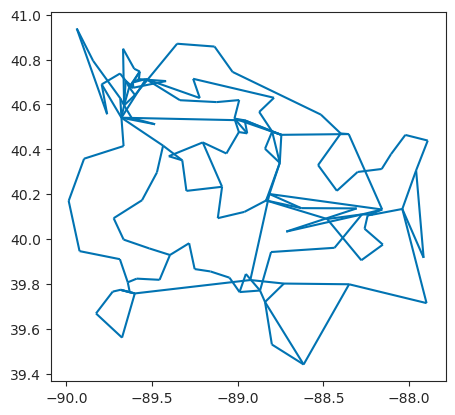

In [10]:
#####################################
##########bus_df
####################################

b_df = bus_df[["BusNum", "Latitude", "Longitude"]].set_index("BusNum").copy()
# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
bus_gdf = gpd.GeoDataFrame(
    b_df,
    geometry=gpd.points_from_xy(b_df["Longitude"], b_df["Latitude"]),
    crs="epsg:4326",
)
bus_gdf


###### OPTIONAL: make bus "sizes" reflect the number of buses at the same latlon
df = bus_gdf.copy()
df["subgraph"] = 1


df = (
    df[["Latitude", "Longitude", "subgraph"]]
    .groupby(["Latitude", "Longitude"])
    .transform("count")
)
df

bus_gdf["size"] = df["subgraph"] * 10
bus_gdf

####  unique latlons
bus_unique_gdf = bus_gdf.drop_duplicates(["Latitude", "Longitude"])
print("\nnumber of unique latlons: {} out of 2000".format(len(bus_unique_gdf)))
bus_unique_gdf


####

###########################################
############ branch_df
##############################################

br_df = branch_df[
    [
        "FromBus",
        "ToBus",
        "from_latitude",
        "from_longitude",
        "to_latitude",
        "to_longitude",
    ]
].copy()

############## make from/to Points

br_df["FromPoint"] = [
    Point(x, y) for x, y in zip(br_df["from_longitude"], br_df["from_latitude"])
]
br_df["ToPoint"] = [
    Point(x, y) for x, y in zip(br_df["to_longitude"], br_df["to_latitude"])
]


############ lines
br_df["geometry"] = [
    LineString([x1, x2]) for x1, x2 in zip(br_df["FromPoint"], br_df["ToPoint"])
]


# “EPSG:4326” WGS84 Latitude/Longitude, used in GPS
br_gdf = gpd.GeoDataFrame(br_df, geometry="geometry", crs="epsg:4326")

br_gdf.plot()

br_df


bus_gdf = bus_gdf.to_crs(epsg=3857)
br_gdf = br_gdf.to_crs(epsg=3857)

## HSDS
* https://github.com/NREL/hsds-examples/tree/master
* cmdlines/hsds


In [ ]:
with h5pyd.Folder("/nrel/wtk/conus-5min/") as f:
    print(list(f))

In [34]:
### test hsds connection
folder = "/nrel/"
with h5pyd.Folder(folder) as f:
    print(f"\n {folder}:")
    for i in range(len(list(f))):
        print(list(f)[i])

folder = "/nrel/wtk/"
with h5pyd.Folder(folder) as f:
    print(f"\n {folder}:")
    for i in range(len(list(f))):
        print(list(f)[i])


 /nrel/:
US_wave
building_synthetic_dataset
dsgrid-2018-efs
nsrdb
porotomo
sup3rcc
umcm
wtk-us.h5
wtk

 /nrel/wtk/:
wtk
NOW-WAKES_Mid_Atlantic
alaska
bangladesh
canada-5min
canada
canada_bc
central_asia
conus-5min
conus
great_lakes-5min
great_lakes
gulf_of_mexico
hawaii-5min
hawaii
india
kazakhstan
led
maine
mexico-5min
mexico
mid_atlantic-5min
mid_atlantic
north_america
now23_california
nw_pacific-5min
nw_pacific
offshore_ca-5min
offshore_ca
philippines
pr100
seasiawind
seasiawind_v2
seasiawind_v3
south_atlantic
sup3rwind
vietnam


In [47]:
####################################
#### search folders

folder = "/nrel/wtk/conus-5min/"
with h5pyd.Folder(folder) as f:
    print(f"\n {folder}:")
    for i in range(len(list(f))):
        print(list(f)[i])

folder = "/nrel/wtk/conus/"
with h5pyd.Folder(folder) as f:
    print(f"\n {folder}:")
    for i in range(len(list(f))):
        print(list(f)[i])


 /nrel/wtk/conus-5min/:
v2.0.0
wtk_conus_2007.h5
wtk_conus_2008.h5
wtk_conus_2009.h5
wtk_conus_2010.h5
wtk_conus_2011.h5
wtk_conus_2012.h5
wtk_conus_2013.h5
wtk_conus_2014.h5

 /nrel/wtk/conus/:
wtk_conus_2007.h5
wtk_conus_2008.h5
wtk_conus_2009.h5
wtk_conus_2010.h5
wtk_conus_2011.h5
wtk_conus_2012.h5
wtk_conus_2013.h5
wtk_conus_2014.h5
wtk_conus_2019.h5
wtk_conus_2020.h5


### WTK-LED dataset
* https://data.openei.org/s3_viewer?bucket=nrel-pds-wtk&prefix=conus%2Fconus_5min%2Fv2.0.0%2F
* aws S3: nrel-pds-wtk/conus/conus_5min/v2.0.0


In [42]:
folder = "/nrel/wtk/conus-5min/v2.0.0/"
with h5pyd.Folder(folder) as f:
    print(f"\n {folder}:")
    for i in range(len(list(f))):
        print(list(f)[i])


 /nrel/wtk/conus-5min/v2.0.0/:
conus_2018.h5
conus_2019.h5
conus_2020.h5


In [46]:
#######################################
### WTK-LED dataset

folder = "/nrel/wtk/conus-5min/v2.0.0/"
with h5pyd.Folder(folder) as f:
    print(f"\n {folder}:")
    for i in range(len(list(f))):
        print(list(f)[i])

# on HSDS
res_file = f"{folder}conus_2018.h5"
# res_file = f"/nrel/wtk/conus-5min/v2.0.0/conus_2018.h5"
res = rex.resource_extraction.resource_extraction.ResourceX(res_file, hsds=True)

meta_df = res.meta
ti = res.time_index
coords = res.coordinates

print("meta_df:")
meta
print("time index:")
ti
print("coords:")
coords
print("dsets:")
res.dsets

var = "windspeed_100m"

ti = res.time_index
gids = [0, 1, 2, 3, 4]
df = pd.DataFrame(
    res[var, :, gids],
    index=res.time_index,
)
df


 /nrel/wtk/conus-5min/v2.0.0/:
conus_2018.h5
conus_2019.h5
conus_2020.h5
meta_df:


,latitude,longitude,country,state,county,timezone,elevation,offshore
gid,,,,,,,,
0,50.756886,-136.477371,Canada,None,None,-9.0,0.0,1
1,50.773338,-136.490936,Canada,None,None,-9.0,0.0,1
2,50.789787,-136.504517,Canada,None,None,-9.0,0.0,1
3,50.806236,-136.518097,Canada,None,None,-9.0,0.0,1
...,...,...,...,...,...,...,...,...
4679358,50.231022,-57.913208,Canada,None,None,-4.0,0.0,1
4679359,50.247314,-57.899261,Canada,None,None,-4.0,0.0,1
4679360,50.263596,-57.885315,Canada,None,None,-3.5,0.0,1
4679361,50.279884,-57.871338,Canada,None,None,-3.5,0.0,1


time index:


DatetimeIndex(['2018-01-01 00:00:00+00:00', '2018-01-01 00:05:00+00:00',
               '2018-01-01 00:10:00+00:00', '2018-01-01 00:15:00+00:00',
               '2018-01-01 00:20:00+00:00', '2018-01-01 00:25:00+00:00',
               '2018-01-01 00:30:00+00:00', '2018-01-01 00:35:00+00:00',
               '2018-01-01 00:40:00+00:00', '2018-01-01 00:45:00+00:00',
               ...
               '2018-12-31 23:10:00+00:00', '2018-12-31 23:15:00+00:00',
               '2018-12-31 23:20:00+00:00', '2018-12-31 23:25:00+00:00',
               '2018-12-31 23:30:00+00:00', '2018-12-31 23:35:00+00:00',
               '2018-12-31 23:40:00+00:00', '2018-12-31 23:45:00+00:00',
               '2018-12-31 23:50:00+00:00', '2018-12-31 23:55:00+00:00'],
              dtype='datetime64[ns, UTC]', length=105120, freq=None)

coords:


array([[  50.756886, -136.47737 ],
       [  50.77334 , -136.49094 ],
       [  50.789787, -136.50452 ],
       ...,
       [  50.247314,  -57.89926 ],
       [  50.263596,  -57.885315],
       [  50.279884,  -57.871338]], dtype=float32)

dsets:


['coordinates',
 'meta',
 'time_index',
 'turbulent_kinetic_energy_1000m',
 'turbulent_kinetic_energy_100m',
 'turbulent_kinetic_energy_200m',
 'turbulent_kinetic_energy_20m',
 'turbulent_kinetic_energy_300m',
 'turbulent_kinetic_energy_40m',
 'turbulent_kinetic_energy_500m',
 'turbulent_kinetic_energy_60m',
 'turbulent_kinetic_energy_80m',
 'winddirection_1000m',
 'winddirection_100m',
 'winddirection_10m',
 'winddirection_120m',
 'winddirection_140m',
 'winddirection_160m',
 'winddirection_180m',
 'winddirection_200m',
 'winddirection_20m',
 'winddirection_250m',
 'winddirection_300m',
 'winddirection_40m',
 'winddirection_500m',
 'winddirection_60m',
 'winddirection_80m',
 'windspeed_1000m',
 'windspeed_100m',
 'windspeed_10m',
 'windspeed_120m',
 'windspeed_140m',
 'windspeed_160m',
 'windspeed_180m',
 'windspeed_200m',
 'windspeed_20m',
 'windspeed_250m',
 'windspeed_300m',
 'windspeed_40m',
 'windspeed_500m',
 'windspeed_60m',
 'windspeed_80m']

,0,1,2,3,4
2018-01-01 00:00:00+00:00,13.28,13.40,13.47,13.53,13.69
2018-01-01 00:05:00+00:00,13.47,13.51,13.52,13.53,13.62
2018-01-01 00:10:00+00:00,13.44,13.45,13.45,13.46,13.53
2018-01-01 00:15:00+00:00,13.37,13.38,13.37,13.38,13.46
...,...,...,...,...,...
2018-12-31 23:40:00+00:00,14.66,14.37,14.18,14.05,13.82
2018-12-31 23:45:00+00:00,14.63,14.33,14.13,14.00,13.76
2018-12-31 23:50:00+00:00,14.59,14.29,14.09,13.95,13.71
2018-12-31 23:55:00+00:00,14.56,14.25,14.04,13.90,13.66


## sup3rcc datasets

* European GCM: conus_ecearth3_ssp585_r1i1p1f1
* Japanese GCM: conus_mriesm20_ssp585_r1i1p1f1


In [38]:
folder = "/nrel/sup3rcc/conus_ecearth3_ssp585_r1i1p1f1/"
with h5pyd.Folder(folder) as f:
    print(f"\n {folder}:")
    for i in range(len(list(f))):
        print(list(f)[i])


 /nrel/sup3rcc/conus_ecearth3_ssp585_r1i1p1f1/:
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2015.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2016.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2017.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2018.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2019.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2020.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2021.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2022.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2023.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2024.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2025.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2026.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2027.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2028.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2029.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2030.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2031.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2032.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2033.h5
sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2034.h5
sup3rcc_con

In [41]:
#######################################
### sup3rcc dataset

### chose Global Climate Model
gcm = "ecearth3"  # European GCM
# gcm = "mriesm20"  # Japanese GCM

folder = f"/nrel/sup3rcc/conus_{gcm}_ssp585_r1i1p1f1/"

# with h5pyd.Folder(folder) as f:
#     print(f"\n {folder}:")
#     for i in range(len(list(f))):
#         print(list(f)[i])

# on HSDS
res_file = f"{folder}sup3rcc_conus_ecearth3_ssp585_r1i1p1f1_2040.h5"
# res_file = f"/nrel/wtk/conus-5min/v2.0.0/conus_2018.h5"
res = rex.resource_extraction.resource_extraction.ResourceX(res_file, hsds=True)

meta_df = res.meta
ti = res.time_index

print("meta_df:")
meta
print("time index:")
ti
print("dsets:")
res.dsets

meta_df:


,latitude,longitude,country,state,county,timezone,elevation,offshore
gid,,,,,,,,
0,50.756886,-136.477371,Canada,None,None,-9.0,0.0,1
1,50.773338,-136.490936,Canada,None,None,-9.0,0.0,1
2,50.789787,-136.504517,Canada,None,None,-9.0,0.0,1
3,50.806236,-136.518097,Canada,None,None,-9.0,0.0,1
...,...,...,...,...,...,...,...,...
4679358,50.231022,-57.913208,Canada,None,None,-4.0,0.0,1
4679359,50.247314,-57.899261,Canada,None,None,-4.0,0.0,1
4679360,50.263596,-57.885315,Canada,None,None,-3.5,0.0,1
4679361,50.279884,-57.871338,Canada,None,None,-3.5,0.0,1


time index:


DatetimeIndex(['2040-01-01 00:00:00+00:00', '2040-01-01 01:00:00+00:00',
               '2040-01-01 02:00:00+00:00', '2040-01-01 03:00:00+00:00',
               '2040-01-01 04:00:00+00:00', '2040-01-01 05:00:00+00:00',
               '2040-01-01 06:00:00+00:00', '2040-01-01 07:00:00+00:00',
               '2040-01-01 08:00:00+00:00', '2040-01-01 09:00:00+00:00',
               ...
               '2040-12-31 14:00:00+00:00', '2040-12-31 15:00:00+00:00',
               '2040-12-31 16:00:00+00:00', '2040-12-31 17:00:00+00:00',
               '2040-12-31 18:00:00+00:00', '2040-12-31 19:00:00+00:00',
               '2040-12-31 20:00:00+00:00', '2040-12-31 21:00:00+00:00',
               '2040-12-31 22:00:00+00:00', '2040-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8784, freq=None)

dsets:


['dhi',
 'dni',
 'ghi',
 'meta',
 'pressure_0m',
 'relativehumidity_2m',
 'temperature_2m',
 'time_index',
 'winddirection_100m',
 'winddirection_10m',
 'winddirection_200m',
 'windspeed_100m',
 'windspeed_10m',
 'windspeed_200m']

In [13]:
# on HSDS
res_file = "/nrel/wtk/conus-5min/wtk_conus_2007.h5"
res = rex.resource_extraction.resource_extraction.ResourceX(res_file, hsds=True)

###### create TAMU box, rectangle that includes entire grid selected above
extra_lat = 0.3
extra_lon = 0.3
top = bus_df["Latitude"].max() + extra_lat
bottom = bus_df["Latitude"].min() - extra_lat
right = bus_df["Longitude"].max() + extra_lon
left = bus_df["Longitude"].min() - extra_lon

gids = res.box_gids((top, left), (bottom, right))


pp_df = pd.DataFrame(index=gids)
pp_df.index.name = "gid"
# 'default' will be defined in config_gen.json
pp_df["config"] = "default"
pp_df

,config
gid,
1578401,default
1578402,default
1578403,default
1578404,default
...,...
1723329,default
1723330,default
1723331,default
1724517,default


In [ ]:
# # on HSDS
# res_file = "/nrel/wtk/conus-5min/wtk_conus_2007.h5"
# res = rex.resource_extraction.resource_extraction.ResourceX(res_file, hsds=True)

# wind resource file on Eagle
# res_file = "/lustre/eaglefs/OLD-datasets/WIND/conus/v1.0.0/wtk_conus_2007.h5"
year = 2007
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013]
# years = [2007,2008]

### this is on lustre file sytem (works)
# res_file = f"/lustre/eaglefs/OLD-datasets/WIND/conus/v1.0.0/wtk_conus_{year}.h5"


# ### vast flash-based system (works) HOURLY
# res_file = f"/vast/datasets/WIND/conus/v1.0.0/wtk_conus_{years[0]}.h5"

# ### vast flash-based system (works) 5-MIN
# res_file = f"/vast/datasets/WIND/conus/v1.0.0/{years[0]}/wtk_conus_{years[0]}_120m.h5"

# ### Kestrel 5-min, lustre (there is no vast flash-based on Kestrel)
# res_file = f"/kfs2/pdatasets/WIND/conus/v1.0.0/{years[0]}/wtk_conus_{years[0]}_120m.h5"
# res = rex.resource_extraction.resource_extraction.ResourceX(res_file,)


###### create TAMU box, rectangle that includes entire grid selected above
extra_lat = 0.3
extra_lon = 0.3
top = bus_df["Latitude"].max() + extra_lat
bottom = bus_df["Latitude"].min() - extra_lat
right = bus_df["Longitude"].max() + extra_lon
left = bus_df["Longitude"].min() - extra_lon

gids = res.box_gids((top, left), (bottom, right))


pp_df = pd.DataFrame(index=gids)
pp_df.index.name = "gid"
# 'default' will be defined in config_gen.json
pp_df["config"] = "default"
pp_df


# #scratch dir
# df.to_csv('/scratch/isatkaus/projects/dispatches/experiments/full_pipeline_execution/pp.csv')
# df.to_csv('/scratch/isatkaus/projects/dispatches/experiments/wind_gen/pp.csv')
pp_df.to_csv(os.path.join(run_dir, "pp.csv"))

In [13]:
### save project points with lat/lons for possible plotting
## get mata data of the resource (we need latlons)
meta_df = res.meta
meta_df
filename = "meta_df.csv"
meta_df.to_csv(os.path.join(run_dir, filename))
### get latlons of pp points only for visualization
pps_df = meta_df.loc[pp_df.index, ["latitude", "longitude"]]
pps_df

### save pps_df
run_dir
filename = "pps_df.csv"
pps_df.to_csv(os.path.join(run_dir, filename))

,latitude,longitude,country,state,county,timezone,elevation,offshore
gid,,,,,,,,
0,37.603382,-127.617050,None,None,None,-9,0,1
1,37.620419,-127.626007,None,None,None,-9,0,1
2,37.637451,-127.634979,None,None,None,-9,0,1
3,37.654484,-127.643951,None,None,None,-9,0,1
...,...,...,...,...,...,...,...,...
2488132,40.351830,-65.745911,None,None,None,-4,0,1
2488133,40.369072,-65.736938,None,None,None,-4,0,1
2488134,40.386314,-65.727936,None,None,None,-4,0,1
2488135,40.403545,-65.718933,None,None,None,-4,0,1


,latitude,longitude
gid,,
1578401,41.145519,-90.285706
1578402,41.164040,-90.283936
1578403,41.182556,-90.282166
1578404,41.201092,-90.280426
...,...,...
1723329,39.306717,-87.596405
1723330,39.325130,-87.593903
1723331,39.343555,-87.591400
1724517,39.157475,-87.592682


'/home/isatkaus/projects/hpcapps/grid-buildouts-data/rev-runs/wind-gen-tamu200-v8'